# Parking Space Detection
Cloning M-RCNN repository

In [1]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.81 MiB | 33.80 MiB/s, done.
Resolving deltas: 100% (571/571), done.


### Importing required modules

In [2]:
import os
os.chdir("Mask_RCNN/")

import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path
from google.colab.patches import cv2_imshow
import pickle

from shapely.geometry import box
from shapely.geometry import Polygon as shapely_poly
from IPython.display import clear_output, Image, display, HTML
import io
import base64
%matplotlib inline

Using TensorFlow backend.


### Configuring M-RCNN

In [3]:
class Config(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 81

config = Config()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
ROOT_DIR = Path(".")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

### Download pre-trained Model

In [5]:
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


# Loading pre-trained model 

In [6]:
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=Config())








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [7]:
model.load_weights(COCO_MODEL_PATH, by_name=True)

#### Create data directory

In [0]:
#  This will contain test videos and images
if not os.path.exists("./data"):
    os.makedirs("./data")

### Uploading data
upload your video file and praking regions file using the sidebar. See image for reference.

![alt text](https://i.imgur.com/UMu9xV5.png)

After uploading the files. Edit the cell below to load the correct files.

In [0]:
VIDEO_SOURCE = "data/parking1.mp4"
PARKING_REGIONS = "data/regions1.p"
with open(PARKING_REGIONS, 'rb') as f:
    parked_car_boxes = pickle.load(f)

### Function to filter out car boxes

In [0]:
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

### Function to compute IoU

In [0]:
def compute_overlaps(parked_car_boxes, car_boxes):
    
    new_car_boxes = []
    for box in car_boxes:
        y1 = box[0]
        x1 = box[1]
        y2 = box[2]
        x2 = box[3]
        
        p1 = (x1, y1)
        p2 = (x2, y1)
        p3 = (x2, y2)
        p4 = (x1, y2)
        new_car_boxes.append([p1, p2, p3, p4])
    
    overlaps = np.zeros((len(parked_car_boxes), len(new_car_boxes)))
    for i in range(len(parked_car_boxes)):
        for j in range(car_boxes.shape[0]):
            pol1_xy = parked_car_boxes[i]
            pol2_xy = new_car_boxes[j]
            polygon1_shape = shapely_poly(pol1_xy)
            polygon2_shape = shapely_poly(pol2_xy)

            polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
            polygon_union = polygon1_shape.union(polygon2_shape).area
            IOU = polygon_intersection / polygon_union
            overlaps[i][j] = IOU

    return overlaps

### Function to display processed images

In [0]:
def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

### Putting it all together

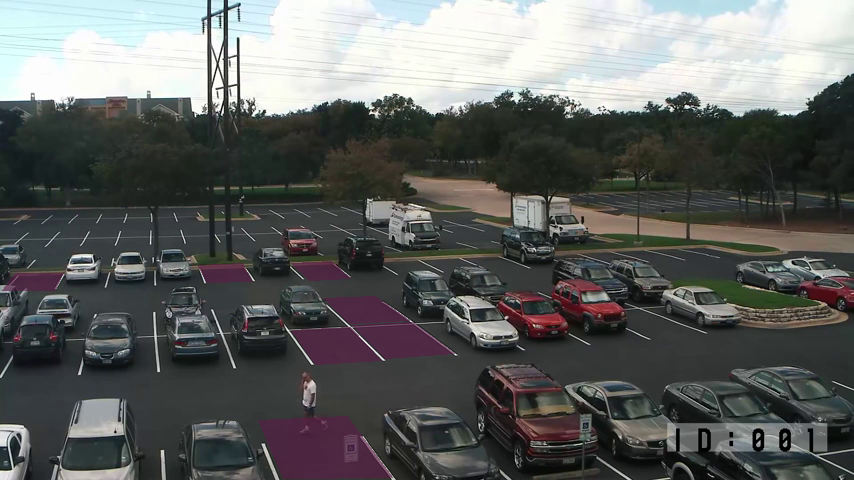

AttributeError: ignored

In [13]:
alpha = 0.6
video_capture = cv2.VideoCapture(VIDEO_SOURCE)
cnt=0

video_FourCC    = cv2.VideoWriter_fourcc('M','J','P','G')
video_fps       = video_capture.get(cv2.CAP_PROP_FPS)
video_size      = (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
                    int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
out = cv2.VideoWriter("out.avi", video_FourCC, video_fps, video_size)

while video_capture.isOpened():
    success, frame = video_capture.read()
    overlay = frame.copy()
    if not success:
        break

    rgb_image = frame[:, :, ::-1]
    results = model.detect([rgb_image], verbose=0)

    car_boxes = get_car_boxes(results[0]['rois'], results[0]['class_ids'])
    overlaps = compute_overlaps(parked_car_boxes, car_boxes)

    for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):
        max_IoU_overlap = np.max(overlap_areas)
        if max_IoU_overlap < 0.15:
            cv2.fillPoly(overlay, [np.array(parking_area)], (71, 27, 92))
            free_space = True      
    cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)

    out.write(frame)

    clear_output(wait=True)
    img = arrayShow(frame)
    display(img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
out.release()
cv2.destroyAllWindows()